In [1]:
%load_ext lab_black

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import admix_genet_cor
import itertools
import admix
from tqdm import tqdm
import os
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import glob
import string
from scipy import stats


import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp-tables.xlsx?dl=1"
snpset = "imputed.mafukb.005"

In [3]:
# UKB
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="ukb-trait-info")
ukb_trait_list = df_trait_info[df_trait_info["in-analysis"] == "T"].id.values
ukb_name_dict = (
    df_trait_info[["id", "display-name"]].set_index("id")["display-name"].to_dict()
)

# PAGE
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="page-trait-info")
page_trait_list = df_trait_info.trait.values
page_name_dict = (
    df_trait_info[["trait", "display-name"]]
    .set_index("trait")["display-name"]
    .to_dict()
)

In [4]:
def read_estimate(snpset):
    dict_loglik = dict()
    dict_nindiv = dict()
    rho_list = np.linspace(0, 1, 21)
    xs = np.linspace(0, 1, 1001)

    for study in ["ukb", "page"]:
        trait_list = ukb_trait_list if study == "ukb" else page_trait_list
        for trait in trait_list:
            if study == "ukb":
                est_dir = (
                    "/u/home/k/kangchen/project-UKBB/UKB-ADMIXED/02-genet-cor/"
                    f"out/gcta-estimate/{trait}-sample10pc-{snpset}"
                )
            else:
                est_dir = (
                    "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/"
                    "03-page-genome-wide-profile-likelihood-new/out/gcta-estimate/"
                    f"{trait}-sample10pc-{snpset}"
                )
            try:
                loglik_list = [
                    admix.tools.gcta.read_reml(
                        os.path.join(est_dir, f"rho{int(rho * 100)}")
                    )["loglik"]
                    for rho in rho_list
                ]
                nindiv = admix.tools.gcta.read_reml(os.path.join(est_dir, "rho100"))[
                    "n"
                ]
                cs = CubicSpline(rho_list, loglik_list)
                ll = cs(xs)
                dict_loglik[(study, trait)] = ll
                dict_nindiv[(study, trait)] = nindiv
            except ValueError as err:
                dict_loglik[(study, trait)] = None
                dict_nindiv[(study, trait)] = None
                print(trait, study, snpset, err)
    return dict_loglik, dict_nindiv

In [5]:
dict_loglik, dict_nindiv = read_estimate("imputed.mafukb.005")

In [6]:
xs = np.linspace(0, 1, 1001)
for study in ["ukb", "page", "overall"]:
    meta_ll = 0
    for trait in dict_loglik:
        if trait not in dict_loglik:
            continue
        if (study in ["ukb", "page"]) and (trait[0] != study):
            continue
        loglik = dict_loglik[trait]
        meta_ll += loglik
    interval = admix_genet_cor.hdi(xs, meta_ll)
    print(
        f"{study}: {meta_ll.argmax() / 1000:.3g} [{interval[0]:.2g}, {interval[1]:.2g}]"
    )

ukb: 0.981 [0.91, 1]
page: 0.902 [0.85, 0.94]
overall: 0.921 [0.88, 0.95]


# Summary

In [7]:
def summarize(dict_loglik, dict_nindiv):
    df_sum = []
    meta_loglik = 0
    for study, trait in dict_loglik:
        if study == "ukb":
            trait_name = ukb_name_dict[trait]
        else:
            trait_name = page_name_dict[trait]

        if dict_loglik[(study, trait)] is None:
            df_sum.append(
                [
                    "UKBB" if study == "ukb" else "PAGE",
                    trait_name,
                    "NA",
                    "NA",
                    "NA",
                    "NA",
                ]
            )
        else:
            loglik = dict_loglik[(study, trait)]
            meta_loglik += loglik
            nindiv = dict_nindiv[(study, trait)]
            mode = loglik.argmax() / 1000
            pval = stats.chi2.sf((loglik.max() - loglik[-1]) * 2, df=1)
            interval = admix_genet_cor.hdi(xs, loglik, ci=0.95)
            if isinstance(interval, tuple):
                interval = f"[{interval[0]:.2f}, {interval[1]:.2f}]"
            elif isinstance(interval, list):
                interval = " ".join([f"[{i[0]:.2f}, {i[1]:.2f}]" for i in interval])

            df_sum.append(
                [
                    "UKBB" if study == "ukb" else "PAGE",
                    trait_name,
                    nindiv,
                    mode,
                    interval,
                    f"{pval:.2g}",
                ]
            )
    meta_interval = admix_genet_cor.hdi(xs, meta_loglik, ci=0.95)
    meta_pval = stats.chi2.sf((meta_loglik.max() - meta_loglik[-1]) * 2, df=1)
    df_sum.append(
        [
            "",
            "Meta analysis",
            "",
            meta_loglik.argmax() / 1000,
            f"[{meta_interval[0]:.2f}, {meta_interval[1]:.2f}]",
            f"{meta_pval:.2g}",
        ]
    )
    df_sum = pd.DataFrame(
        df_sum,
        columns=["Study", "Trait", "N", "Mode", "95% credible interval(s)", "p-value"],
    )
    return df_sum

In [8]:
# see 01-genome-wide-simulate-profile-likelihood/03-plot-hsq.ipynb to get this constant
scale_factor = 0.24884752564563367

In [9]:
def estimate_hsq(dict_est, scale_factor=1):
    """
    Estimate the ratio with delta method, est[0] (var_g) / [est[0] (var_g) + est[1] (var_e)]
    est: (2, ) numpy array
    est_var (2, 2) variance-covariance matrix
    """
    assert len(dict_est["est"]) == 2
    assert np.all(dict_est["est"].Source.values == ["V(G)", "V(e)"])
    est = dict_est["est"].Variance.values
    est_var = dict_est["varcov"].values

    ## method 1
    x, y = est[0], est[1]
    hsq = (x * scale_factor) / (x * scale_factor + y)

    # grad = [y / (x + y)^2, - x / (x + y)^2]
    grad = np.array(
        [
            scale_factor * y / ((scale_factor * x + y) ** 2),
            -scale_factor * x / ((scale_factor * x + y) ** 2),
        ]
    )

    ## method2
    #     x, y = est[0] * scale_factor, est[1]

    #     est_var[0, :] *= scale_factor
    #     est_var[:, 0] *= scale_factor

    #     hsq = x / (x + y)

    #     # grad = [y / (x + y)^2, - x / (x + y)^2]

    #     grad = np.array([y / ((x + y) ** 2), -x / ((x + y) ** 2)])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return hsq, quad_form(grad, est_var)

# Read hsq estimates

In [10]:
df_hsq = {"Study": [], "Trait": [], "hsq": []}

for study in ["ukb", "page"]:
    trait_list = ukb_trait_list if study == "ukb" else page_trait_list
    for trait in trait_list:
        if study == "ukb":
            est_dir = (
                "/u/home/k/kangchen/project-UKBB/UKB-ADMIXED/02-genet-cor/"
                f"out/gcta-estimate/{trait}-sample10pc-{snpset}"
            )
        else:
            est_dir = (
                "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/"
                "03-page-genome-wide-profile-likelihood-new/out/gcta-estimate/"
                f"{trait}-sample10pc-{snpset}"
            )
        dict_est = admix.tools.gcta.read_reml(os.path.join(est_dir, f"rho100"))
        est, est_var = estimate_hsq(dict_est, scale_factor=scale_factor)

        if study == "ukb":
            trait_name = ukb_name_dict[trait]
        else:
            trait_name = page_name_dict[trait]
        df_hsq["Study"].append({"ukb": "UKBB", "page": "PAGE"}[study])
        df_hsq["Trait"].append(trait_name)
        df_hsq["hsq"].append(f"${est:.3g} \pm {np.sqrt(est_var):.2g}$")
df_hsq = pd.DataFrame(df_hsq)

In [11]:
df_sum = summarize(dict_loglik, dict_nindiv)
df_sum.to_excel("numerical.xlsx", index=False)

In [12]:
print(
    "UKB: {ukb_n_trait} traits (average N={ukb_n:.0f}). PAGE: {page_n_trait} traits (average N={page_n:.0f})".format(
        ukb_n_trait=sum(df_sum.Study == "UKBB"),
        ukb_n=df_sum[df_sum.Study == "UKBB"]["N"].mean(),
        page_n_trait=sum(df_sum.Study == "PAGE"),
        page_n=df_sum[df_sum.Study == "PAGE"]["N"].mean(),
    )
)

UKB: 26 traits (average N=3808). PAGE: 24 traits (average N=9296)


In [13]:
assert df_sum[["Study", "Trait"]].iloc[0:50].equals(df_hsq[["Study", "Trait"]])

In [14]:
df_sum["$\widehat{h_g^2}$"] = ""
df_sum.iloc[0:50, 6] = df_hsq["hsq"]

In [15]:
print(df_sum.to_latex(escape=False, index=False))

\begin{tabular}{lllrlll}
\toprule
Study &                    Trait &     N &  Mode &  95% credible interval(s) & p-value &   $\widehat{h_g^2}$ \\
\midrule
 UKBB &           Hypothyroidism &  4063 & 1.000 &              [0.05, 1.00] &       1 &  $0.0436 \pm 0.067$ \\
 UKBB &          Type 1 diabetes &  3767 & 0.381 &              [0.00, 0.95] &    0.77 & $-0.0308 \pm 0.015$ \\
 UKBB &          Type 2 diabetes &  4114 & 0.920 &              [0.06, 1.00] &    0.82 &  $0.0856 \pm 0.068$ \\
 UKBB &             Hypertension &  4127 & 0.983 &              [0.09, 1.00] &    0.93 &   $0.155 \pm 0.079$ \\
 UKBB &                   Asthma &  4079 & 1.000 &              [0.15, 1.00] &       1 &     $0.2 \pm 0.084$ \\
 UKBB &        Total cholesterol &  3898 & 0.972 &              [0.36, 1.00] &    0.81 &   $0.304 \pm 0.087$ \\
 UKBB & Diastolic blood pressure &  4017 & 1.000 &              [0.07, 1.00] &       1 &   $0.133 \pm 0.081$ \\
 UKBB &   RBC distribution width &  3925 & 1.000 &           

In [16]:
# trait that's nominally significant
display(
    df_sum[df_sum["p-value"].astype(float) < 0.05].style.set_caption(
        "Traits that are nominally significant"
    )
)

# trait that's significant after Bonferrnoni correction
display(
    df_sum[
        df_sum["p-value"].astype(float) < 0.05 / (len(df_sum) - 1)
    ].style.set_caption("Traits that are bonferroni significant")
)

,Study,Trait,N,Mode,95% credible interval(s),p-value,$\widehat{h_g^2}$
15,UKBB,BMD,1668,0.000000,"[0.00, 0.78]",0.012,$0.326 \pm 0.16$
33,PAGE,Total cholesterol,9981,0.696000,"[0.10, 0.92]",0.0053,$0.176 \pm 0.036$
47,PAGE,Height,16705,0.902000,"[0.81, 0.97]",0.0042,$0.388 \pm 0.025$
50,,Meta analysis,,0.921000,"[0.88, 0.95]",6.8e-07,


,Study,Trait,N,Mode,95% credible interval(s),p-value,$\widehat{h_g^2}$
50,,Meta analysis,,0.921000,"[0.88, 0.95]",6.8e-07,


In [13]:
df_ukb = df_sum[df_sum.Study == "UKB"]
df_page = df_sum[df_sum.Study == "PAGE"]
df_merged = pd.merge(df_ukb, df_page, on=["Trait"], suffixes=["_ukb", "_page"])

print(f"{len(df_merged)} traits in common between UKB and PAGE")
print(
    "Spearman correlation of -log10[p] from two studies: {:.2g}".format(
        stats.spearmanr(
            df_merged["p-value_ukb"].astype(float),
            df_merged["p-value_page"].astype(float),
        )[1]
    )
)

13 traits in common between UKB and PAGE
Spearman correlation of -log10[p] from two studies: 0.13


In [14]:
shared_trait_list = [
    "Height",
    "Total cholesterol",
    "Platelet count",
    "Triglycerides",
    "BMI",
    "Type 2 diabetes",
    "White blood cell count",
    "Hypertension",
    "HDL",
    "LDL",
    "HbA1c",
    "Diastolic blood pressure",
    "Systolic blood pressure",
]
assert set(shared_trait_list) == set(df_merged["Trait"])

In [15]:
dict_joint_loglik = {t: 0 for t in shared_trait_list}
dict_joint_nindiv = {t: 0 for t in shared_trait_list}
for study, trait in dict_loglik:
    if study == "ukb":
        trait_name = ukb_name_dict[trait]
    else:
        trait_name = page_name_dict[trait]
    if trait_name in shared_trait_list:

        dict_joint_loglik[trait_name] += dict_loglik[study, trait]
        dict_joint_nindiv[trait_name] += dict_nindiv[study, trait]

dict_est = {
    trait: dict_joint_loglik[trait].argmax() / 1000 for trait in shared_trait_list
}
dict_hdi_50 = {
    trait: admix_genet_cor.hdi(xs, dict_joint_loglik[trait], ci=0.5)
    for trait in shared_trait_list
}

dict_hdi_95 = {
    trait: admix_genet_cor.hdi(xs, dict_joint_loglik[trait], ci=0.95)
    for trait in shared_trait_list
}

dict_joint_pval = {
    trait: stats.chi2.sf((loglik.max() - loglik[-1]) * 2, df=1)
    for trait, loglik in dict_joint_loglik.items()
}
df_joint_pval = pd.DataFrame(
    {"trait": dict_joint_pval.keys(), "pval": dict_joint_pval.values()}
).sort_values("pval")
assert np.all(np.array(shared_trait_list) == df_joint_pval.trait)

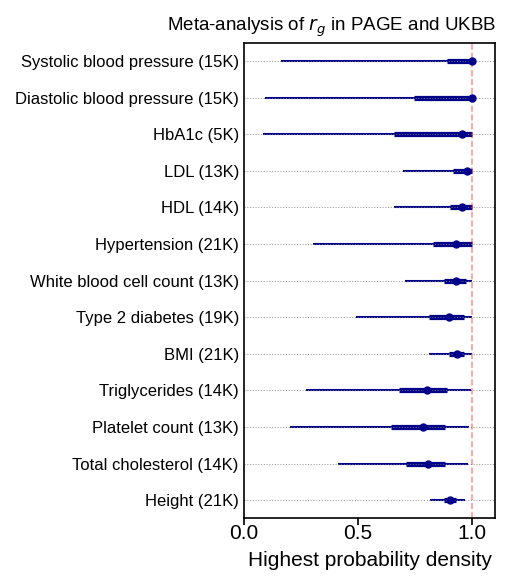

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 4), dpi=150)
est = [dict_est[trait] for trait in dict_est]
err1_50 = [dict_est[trait] - hdi[0] for trait, hdi in dict_hdi_50.items()]
err2_50 = [hdi[1] - dict_est[trait] for trait, hdi in dict_hdi_50.items()]

err1_95 = [dict_est[trait] - hdi[0] for trait, hdi in dict_hdi_95.items()]
err2_95 = [hdi[1] - dict_est[trait] for trait, hdi in dict_hdi_95.items()]

ax.errorbar(
    y=np.arange(len(est)),
    x=est,
    xerr=(err1_50, err2_50),
    fmt=".",
    lw=2.5,
    color="darkblue",
)
ax.errorbar(
    y=np.arange(len(est)),
    x=est,
    xerr=(err1_95, err2_95),
    fmt=" ",
    lw=1.0,
    color="darkblue",
)

for y in np.arange(len(est)):
    ax.axhline(y=y, color="gray", ls="dotted", lw=0.5, alpha=0.8)

ax.set_xlim(0, 1.1)
ax.set_xlabel("Highest probability density")
ax.set_yticks(np.arange(len(est)))
ax.set_ylim(-0.5, len(est) - 0.5)
ax.set_yticklabels(
    [f"{t} ({int(np.round(n / 1000))}K)" for t, n in dict_joint_nindiv.items()],
    fontsize=8,
)

ax.tick_params(left=False, pad=-1)

ax.axvline(x=1.0, color="red", ls="--", lw=0.8, alpha=0.4)
ax.set_title("Meta-analysis of $r_g$ in PAGE and UKBB", fontsize=9, x=0.35)
plt.tight_layout()
plt.savefig("results/shared.pdf", bbox_inches="tight")

# consistency of the estimates using gcta / hm3


In [17]:
# consistency of the estimates using gcta / hm3
df_sum_gcta = summarize(*read_estimate("imputed.gcta.005"))
df_sum_hm3 = summarize(*read_estimate("hm3.mafukb.005"))

250.1 ukb imputed.gcta.005 can only convert an array of size 1 to a Python scalar
250.1 ukb hm3.mafukb.005 can only convert an array of size 1 to a Python scalar
log_lymphocyte ukb hm3.mafukb.005 can only convert an array of size 1 to a Python scalar


In [18]:
df_pval = pd.DataFrame(
    {
        "default": df_sum["p-value"],
        "gcta": df_sum_gcta["p-value"],
        "hm3": df_sum_hm3["p-value"],
    }
)
# remove the meta-analysis results
df_pval = df_pval.iloc[:-1]

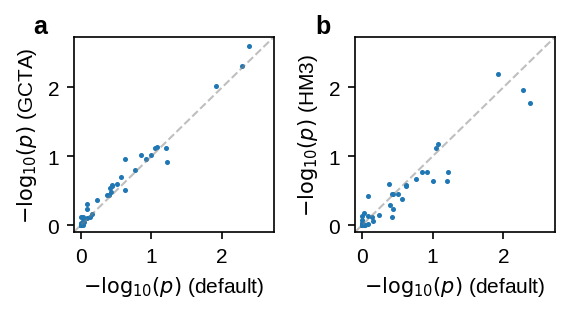

In [19]:
values = df_pval.values.flatten()
lim = -np.log10(values[values != "NA"].astype(float)).min() * 1.05

fig, axes = plt.subplots(figsize=(3.9, 2.2), dpi=150, ncols=2)
for i, compare in enumerate(["gcta", "hm3"]):
    ax = axes[i]
    df_tmp = df_pval[["default", compare]]
    df_tmp = df_tmp[~(df_tmp == "NA").any(axis=1)].astype(float)
    #     admix.plot.compare_pval(df_tmp["default"], df_tmp[compare], s=2, ax=ax)
    ax.scatter(-np.log10(df_tmp["default"]), -np.log10(df_tmp[compare]), s=2)
    ax.set_xlim(-0.1, lim)
    ax.set_ylim(-0.1, lim)
    ax.axline((0, 0), slope=1, color="gray", ls="--", alpha=0.5, lw=1.0)
    ax.set_xlabel("$-\log_{10}(p)$ (default)")
    yname = "GCTA" if compare == "gcta" else "HM3"
    ax.set_ylabel("$-\log_{10}(p)$" + f" ({yname})")
    ax.text(
        -0.2,
        1.02,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

fig.tight_layout()
plt.savefig("results/robustness.pdf", bbox_inches="tight")

In [108]:
# df_tmp = df_sum.iloc[:-1].copy()
# df_tmp["ci"] = df_tmp["95% credible interval(s)"].apply(
#     lambda x: [
#         float(e)
#         for e in x.split("] [")[-1].replace("[", "").replace("]", "").split(",")
#     ]
# )
# df_tmp["yerr1"] = df_tmp.apply(lambda r: r.Mode - r.ci[0], axis=1)
# df_tmp["yerr2"] = df_tmp.apply(lambda r: r.ci[1] - r.Mode, axis=1)

# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(df_tmp["N"], df_tmp["p-value"].astype(float), s=2)
# ax.set_xlabel("Number of individuals")
# ax.set_ylabel("$p$-value")

# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(df_tmp["N"], df_tmp["Mode"].astype(float), s=2)
# ax.set_xlabel("Number of individuals")
# ax.set_ylabel("Mode")

# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# ax.scatter(df_tmp["N"], df_tmp["Mode"].astype(float), s=2)
# ax.errorbar(
#     x=df_tmp["N"],
#     y=df_tmp["Mode"].astype(float),
#     yerr=(df_tmp["yerr1"], df_tmp["yerr2"]),
#     fmt=" ",
#     lw=0.8,
# )

# ax.set_xlabel("Number of individuals")
# ax.set_ylabel("Mode")